In [129]:
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon, Point
from shapely.ops import split

data = np.genfromtxt('https://raw.githubusercontent.com/nttuan8/DL_Tutorial/master/L2/dataset.csv',
                     delimiter=',', skip_header=1, encoding='utf-8')

In [130]:
class Node:
    def __init__(self, var, threshold, gini_score, parent, lchild, rchild):
        self.var = var
        self.threshold = threshold
        self.threshold_var = f'var_{var} > {threshold}'
        self.gini_score = gini_score

        self._parent = parent
        self._lchild = lchild
        self._rchild = rchild

        self.class_name = None

    def __str__(self):
        return self.threshold_var

    def __bool__(self):
        return self.var is not None

    def is_leaf(self):
        return self._lchild is None and self._rchild is None

    def add_class(self, class_name):
        self.class_name = class_name


class BinaryTree:

    def __init__(self):
        self.root = None
        self.size = 0
        self.longest_path = []

    def add_root(self, element):
        if self.root:
            return self.root
        self.root = Node(element, None, None, None)
        self.size += 1
        return self.root

    def get_height(self, node):
        if not node or node.is_leaf():
            return 0
        return 1 + max(self.get_height(node._lchild), self.get_height(node._rchild))

    def get_depth(self, node):
        if not node._parent:
            return 0
        return 1 + self.get_depth(node._parent)

    def add_left_child(self, parent, element):
        if not parent._lchild:
            new = Node(element, parent, None, None)
            parent._lchild = new
            self.size += 1
            return new

    def add_right_child(self, parent, element):
        if not parent._rchild:
            new = Node(element, parent, None, None)
            parent._rchild = new
            self.size += 1
            return new

    def printTree(self, root, level=0):
        if root != None:
            self.printTree(root._lchild, level + 1)
            if root.is_leaf():
                print(' ' * 4 * level + '->', root.class_name)
            else:
                print(' ' * 4 * level + '->', root.threshold_var)
            self.printTree(root._rchild, level + 1)

In [131]:
class DecisionTree:
    stop_tol = 1e-2

    def __init__(self):
        self.tree = BinaryTree()

    def calculate_gini(self, y):
        unique, counts = np.unique(y, return_counts=True)
        return 1 - sum((arg / sum(counts)) ** 2 for arg in counts)

    def get_threshold_element(self, gini_parent_score, X, y):
        n = data.shape[0]
        result = {}
        threshold = {}

        for var in range(X.shape[1]):
            sorted = np.unique(np.sort(X[:, var]))
            for r in np.convolve(sorted, np.ones(2), 'valid') / 2:
                positive_y = y[X[:, var] > r]
                gini_pos = self.calculate_gini(positive_y)

                negative_y = y[X[:, var] <= r]
                gini_neg = self.calculate_gini(negative_y)

                gini_score = len(positive_y) * gini_pos / n + len(negative_y) * gini_neg / n
                result[f'var_{var} > {r}'] = gini_parent_score - gini_score
                threshold[f'var_{var} > {r}'] = {'var': var, 'threshold': r, 'gini_score': gini_score}

        max_threshold = max(result, key=result.get)
        if result[max_threshold] > self.stop_tol:
            return (threshold[max_threshold]['var'],
                    threshold[max_threshold]['threshold'],
                    threshold[max_threshold]['gini_score'])
        return None, None, None

    def add_root(self, X, y):
        if self.tree.root:
            return self.tree.root
        var, threshold, gini_score = self.get_threshold_element(1, X, y)
        self.tree.root = Node(var, threshold, gini_score, None, None, None)
        self.tree.size += 1

    def add_node(self, parent, position, X, y):
        '''
        parent: The parent node
        element: The new element to be added
        postion: left or right
        X, y: training data
        '''
        var, threshold, gini_score = self.get_threshold_element(parent.gini_score, X, y)
        new_node = Node(var, threshold, gini_score,
                        parent, None, None)

        if var is None:
            counts = np.bincount(y)
            new_node.add_class(np.argmax(counts))

        if position == 'left':
            parent._lchild = new_node
        if position == 'right':
            parent._rchild = new_node

        if new_node:
            self.tree.size += 1
            self.add_node(new_node, 'left',
                          X[X[:, new_node.var] > new_node.threshold],
                          y[X[:, new_node.var] > new_node.threshold])

            self.add_node(new_node, 'right',
                          X[X[:, new_node.var] <= new_node.threshold],
                          y[X[:, new_node.var] <= new_node.threshold])
        else:
            return

    def train(self, X, y):
        self.add_root(X, y)

        self.add_node(self.tree.root, 'left',
                      X[X[:, self.tree.root.var] > self.tree.root.threshold],
                      y[X[:, self.tree.root.var] > self.tree.root.threshold])

        self.add_node(x.tree.root, 'right',
                      X[X[:, self.tree.root.var] <= self.tree.root.threshold],
                      y[X[:, self.tree.root.var] <= self.tree.root.threshold])

    def predict_one(self, x):
      current_node = self.tree.root
      while current_node.class_name is None:
        if x[current_node.var] > current_node.threshold:
          current_node = current_node._lchild
        else:
          current_node = current_node._rchild
      return current_node.class_name

    def predict(self, X):
      return np.array(list(map(self.predict_one, X)))

In [132]:
class TreeDraw:
    color = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']

    def __init__(self, min_x, max_x, min_y, max_y):
        self.left_top = (min_x, max_y)
        self.right_top = (max_x, max_y)
        self.left_bottom = (min_x, min_y)
        self.right_bottom = (max_x, min_y)

        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y

        self.plane = Polygon((self.left_top, self.right_top,
                              self.right_bottom, self.left_bottom))

        self.plot = plt.figure()

    def add_data(self, X, y):
        self.X = X
        self.y = y
        self.color_dict = {y_value: color for y_value, color in zip(np.unique(y), self.color)}

        for y_value, color in self.color_dict.items():
            plt.scatter(X[y == y_value, 0], X[y == y_value, 1], c=color)

    def split_polygons(self, right_point, plane, line):
        polygons = split(plane, line)
        if polygons[0].contains(right_point):
            return polygons[0], polygons[1]
        else:
            return polygons[1], polygons[0]

    def draw(self, root, plane=None, data=None):
        if plane is None:
            plane = self.plane

        if root.is_leaf():
            x, y = plane.exterior.xy
            plt.fill(x, y, alpha=0.2, c=self.color_dict[root.class_name])
            return
        else:
            right_point=Point(data[data[:,root.var] <= root.threshold, 0][0],
                              data[data[:,root.var] <= root.threshold, 1][0])
            if root.var == 0:
              right_plane, left_plane = self.split_polygons(right_point, 
                                           plane, 
                                           LineString(((root.threshold, self.min_y),
                                                (root.threshold, self.max_y))))
      
            if root.var == 1:
              right_plane, left_plane = self.split_polygons(right_point, 
                                           plane, LineString(((self.min_x, root.threshold),
                                          (self.max_x, root.threshold))))

            self.draw(root._rchild, right_plane, X)
            self.draw(root._lchild, left_plane, X)


In [133]:
X = data[:,:2]
y = data[:,2].astype('int')
x=DecisionTree()
x.train(X, y)
x.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


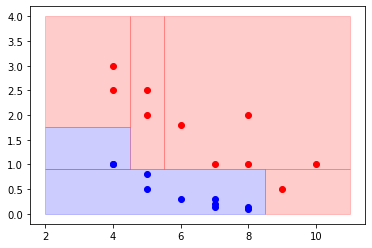

In [121]:
t=TreeDraw(2, 11, 0, 4)
t.add_data(X, y)
t.draw(x.tree.root, data=X)
t.plot.show()